<a href="https://colab.research.google.com/github/Grimalo/cognitive_distortion/blob/main/Multietiqueta_validacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preparación de datasets

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


### D1

In [ ]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import pandas as pd
import kaggle
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import BertTokenizerFast as BertTokenizer, BertModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
from tqdm.auto import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast as BertTokenizer, BertModel, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from torchmetrics import Accuracy, F1Score, AUROC
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.metrics import classification_report, multilabel_confusion_matrix

kaggle.api.dataset_download_files('sagarikashreevastava/cognitive-distortion-detetction-dataset', path='data', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/sagarikashreevastava/cognitive-distortion-detetction-dataset


In [ ]:
# Remapeo
distorsiones_cognitivas_traducidas = {
    "negative feeling or emotion": "Sentimiento o emoción negativa",
    "No Distortion": "Sin distorsión",
    'none' : 'Sin distorsión',
    "Mind Reading": "Lectura de mente",
    "Overgeneralization": "Sobregeneralización",
    "Magnification": "Magnificación",
    "Personalization": "Personalización",
    "Fortune-telling": "Error del adivino",
    'fortune telling': "Error del adivino",
    "Emotional Reasoning": "Razonamiento emocional",
    "Mental filter": "Filtro mental",
    "Should statements": "Debería (frase)",
    "All-or-nothing thinking": "Todo o nada",
    'no distortion': 'Sin distorsión',
    'mind reading': 'Lectura de mente',
    'overgeneralizing': 'Sobregeneralización',
    'ovegeneralization' : 'Sobregeneralización',
    'magnification': 'Magnificación',
    'labeling': 'Etiquetamiento erróneo',
    'personalization': 'Personalización',
    'personalizing' : 'Personalización',
    'fortune-telling': 'Error del adivino',
    'emotional reasoning': 'Razonamiento emocional',
    'mental filter': 'Filtro mental',
    'should statements': 'Debería (frase)',
    'all-or-nothing thinking': 'Todo o nada',
    'disqualifying the positive':'Descalificación de lo positivo',
    'catastrophizing':'catastroficación',
    'blaming':'Culpar a otros',
    "comparing and despairing": "Comparaciones desalentadoras"}

In [ ]:
d1 = pd.read_csv('/content/data/Annotated_data.csv')
d1['Texto'] = d1['Patient Question'] + [x if isinstance(x, str) else ' ' for x in d1['Distorted part']]
d1['Dominant Distortion'] = d1['Dominant Distortion'].replace(distorsiones_cognitivas_traducidas)
d1['Secondary Distortion (Optional)'] = d1['Secondary Distortion (Optional)'].replace(distorsiones_cognitivas_traducidas)
d1['Distorsión'] = d1.apply(lambda x: ','.join([str(y) for y in [x['Dominant Distortion'], x['Secondary Distortion (Optional)']] if pd.notna(y)]), axis=1)
d1['Dataset'] = 'D1'

In [ ]:
d1.to_excel('dataset_1.xlsx')

### D2

In [ ]:
d2 = pd.read_excel('/content/drive/MyDrive/dataseet_chinatraducida.xlsx')

In [ ]:
d2['Texto'] = d2['Situation or Thinking']
d2['Distorsión'] = [",".join(map(lambda x:distorsiones_cognitivas_traducidas[x.lower()], i.split(','))) for i in d2['Cognitive Distortion']]
d2['Dataset'] = 'D2'

### D3

In [ ]:
d3 = pd.read_csv('/content/drive/MyDrive/reframing_dataset.csv')
d3['Texto'] = d3['situation'] + ' ' + d3['thought']
d3['Distorsión'] =  [",".join(map(lambda x:distorsiones_cognitivas_traducidas[x.lower()], i.split(','))) for i in d3['thinking_traps_addressed']]
d3['Dataset'] = 'D3'

In [ ]:
d3.head()

,situation,thought,reframe,thinking_traps_addressed,Texto,Distorsión,Dataset
0,A Roomate of mine stole my comptuer,Someone I trusted stole something valuable of ...,"My roommate stole something of mine, and I wil...",emotional reasoning,A Roomate of mine stole my comptuer Someone I ...,Razonamiento emocional,D3
1,A Roomate of mine stole my comptuer,Someone I trusted stole something valuable of ...,While I would like there to be consequences fo...,emotional reasoning,A Roomate of mine stole my comptuer Someone I ...,Razonamiento emocional,D3
2,"A few days ago, I got angry at my husband's gr...",She doesn't respect me.,She is older and may have been tired,overgeneralizing,"A few days ago, I got angry at my husband's gr...",Sobregeneralización,D3
3,"A few days ago, I got angry at my husband's gr...",She doesn't respect me.,"I felt disrespected by her actions, but that d...",overgeneralizing,"A few days ago, I got angry at my husband's gr...",Sobregeneralización,D3
4,A friend who is a recent widower has started d...,My friend is ignoring his recently-deceased wife.,Maybe my friend is in a healthy spot to date n...,disqualifying the positive,A friend who is a recent widower has started d...,Descalificación de lo positivo,D3


### Prevención de desbalance de clases

In [ ]:
d_comp = pd.concat([d1,d2,d3])
d_comp['Distorsión_temp'] = d_comp['Distorsión'].str.split(',').apply(lambda x:str(len(x)))

In [ ]:
d_comp['Distorsión_temp'].value_counts()

Distorsión_temp
1    3077
2     669
3      79
4      13
5      10
6       4
7       4
8       2
Name: count, dtype: int64

In [ ]:
#Quito valores con una cantidad de distorsiones mayor o igual a 4 para prevenir ruido innecesario
d_comp['Distorsión_temp'] = d_comp['Distorsión_temp'].astype(int)
d_comp = d_comp[d_comp['Distorsión_temp'] < 4]

In [ ]:
# Despivot
distorsiones = d_comp[['Texto', 'Distorsión']]['Distorsión'].str.get_dummies(sep=',')
d_comp_expanded = pd.concat([d_comp[['Texto', 'Distorsión','Dataset']], distorsiones], axis=1)
d_comp_expanded.head()

,Texto,Distorsión,Dataset,Comparaciones desalentadoras,Culpar a otros,Debería (frase),Descalificación de lo positivo,Error del adivino,Etiquetamiento erróneo,Filtro mental,Labeling,Lectura de mente,Magnificación,Personalización,Razonamiento emocional,Sentimiento o emoción negativa,Sin distorsión,Sobregeneralización,Todo o nada,catastroficación
0,"Hello, I have a beautiful,smart,outgoing and a...",Personalización,D1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,Since I was about 16 years old I’ve had these ...,"Labeling,Razonamiento emocional",D1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
2,So I’ve been dating on and off this guy for a...,Sin distorsión,D1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,My parents got divorced in 2004. My mother has...,Sin distorsión,D1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,I don’t really know how to explain the situati...,"Error del adivino,Razonamiento emocional",D1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
#Revisión de balance de datos
d_comp_expanded[d_comp_expanded.columns[3:]].sum()/len(d_comp_expanded) * 100

Comparaciones desalentadoras       0.313725
Culpar a otros                     2.222222
Debería (frase)                    5.385621
Descalificación de lo positivo     1.281046
Error del adivino                 11.555556
Etiquetamiento erróneo             8.496732
Filtro mental                      9.307190
Labeling                           5.307190
Lectura de mente                   9.437908
Magnificación                      8.810458
Personalización                    7.320261
Razonamiento emocional             5.673203
Sentimiento o emoción negativa     3.294118
Sin distorsión                    24.888889
Sobregeneralización               11.111111
Todo o nada                        5.699346
catastroficación                   1.516340
dtype: float64

Vemos que hay características muy poco representadas como:


*   catastroficación
*   Culpar a otros
*   Comparaciones desalentadoras
*   Descalificaciónd de lo positivo
*   Sentimiento o emoción negativa




In [ ]:
para_eliminar = ['catastroficación','Culpar a otros','Comparaciones desalentadoras','Descalificación de lo positivo','Sentimiento o emoción negativa']
dists = []
for i in d_comp['Distorsión']:
  temp_dists = []
  for j in i.split(','):
    if j in para_eliminar:
      continue
    else:
      temp_dists.append(j)
  temp_dists = ','.join(temp_dists)
  dists.append(temp_dists)

d_comp['Distorsión'] = dists

In [ ]:
# Despivot
distorsiones = d_comp[['Texto', 'Distorsión']]['Distorsión'].str.get_dummies(sep=',')
d_comp_expanded = pd.concat([d_comp[['Texto', 'Distorsión','Dataset']], distorsiones], axis=1)
d_comp_expanded[d_comp_expanded.columns[3:]].sum()/len(d_comp_expanded) * 100

Debería (frase)            5.385621
Error del adivino         11.555556
Etiquetamiento erróneo     8.496732
Filtro mental              9.307190
Labeling                   5.307190
Lectura de mente           9.437908
Magnificación              8.810458
Personalización            7.320261
Razonamiento emocional     5.673203
Sin distorsión            24.888889
Sobregeneralización       11.111111
Todo o nada                5.699346
dtype: float64

In [ ]:
d_comp_expanded = d_comp_expanded.drop('Sin distorsión', axis=1) #Si no tiene ninguna otra se asume que no tiene distorsión

### Preparación de datos de prueba y validación

In [ ]:
d1_expanded = d_comp_expanded[d_comp_expanded['Dataset']=='D1']
d2_expanded = d_comp_expanded[d_comp_expanded['Dataset']=='D2']
d3_expanded = d_comp_expanded[d_comp_expanded['Dataset']=='D3']

In [ ]:
d1_expanded

,Texto,Distorsión,Dataset,Debería (frase),Error del adivino,Etiquetamiento erróneo,Filtro mental,Labeling,Lectura de mente,Magnificación,Personalización,Razonamiento emocional,Sobregeneralización,Todo o nada
0,"Hello, I have a beautiful,smart,outgoing and a...",Personalización,D1,0,0,0,0,0,0,0,1,0,0,0
1,Since I was about 16 years old I’ve had these ...,"Labeling,Razonamiento emocional",D1,0,0,0,0,1,0,0,0,1,0,0
2,So I’ve been dating on and off this guy for a...,Sin distorsión,D1,0,0,0,0,0,0,0,0,0,0,0
3,My parents got divorced in 2004. My mother has...,Sin distorsión,D1,0,0,0,0,0,0,0,0,0,0,0
4,I don’t really know how to explain the situati...,"Error del adivino,Razonamiento emocional",D1,0,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2525,I’m a 21 year old female. I spent most of my l...,Sin distorsión,D1,0,0,0,0,0,0,0,0,0,0,0
2526,I am 21 female and have not had any friends fo...,Sobregeneralización,D1,0,0,0,0,0,0,0,0,0,1,0
2527,From the U.S.: My brother is 19 years old and ...,"Filtro mental,Lectura de mente",D1,0,0,0,1,0,1,0,0,0,0,0
2528,From the U.S.: I am a 21 year old woman who ha...,Sin distorsión,D1,0,0,0,0,0,0,0,0,0,0,0


Estratificando cada dataset

In [ ]:
from sklearn.model_selection import train_test_split
#Una muy buena practica sería estratificar los datos de train y test tambien, para que las proporcioens sean las mismas, pero no lo hare xq es mucha cosa (tal vez para mejorar el modelo)

X_d1_train, X_d1_test, y_d1_train, y_d1_test = train_test_split(d1_expanded['Texto'],
                                                                d1_expanded[d1_expanded.columns[3:]],
                                                                test_size = 0.2,
                                                                random_state = 42,
                                                                )

X_d2_train, X_d2_test, y_d2_train, y_d2_test = train_test_split(d2_expanded['Texto'],
                                                                d2_expanded[d2_expanded.columns[3:]],
                                                                test_size = 0.2,
                                                                random_state = 42,
                                                                )

X_d3_train, X_d3_test, y_d3_train, y_d3_test = train_test_split(d3_expanded['Texto'],
                                                                d3_expanded[d1_expanded.columns[3:]],
                                                                test_size = 0.2,
                                                                random_state = 42,
                                                                )


In [ ]:
X_train = pd.concat([X_d1_train,X_d2_train,X_d3_train])
y_train = pd.concat([y_d1_train,y_d2_train,y_d3_train])
train_dataset = pd.concat([X_train,y_train],axis=1)


In [ ]:
X_test = pd.concat([X_d1_test,X_d2_test,X_d3_test])
y_test = pd.concat([y_d1_test,y_d2_test,y_d3_test])
test_dataset = pd.concat([X_test,y_test],axis=1)

# Entrenamiento del modelo

In [ ]:
!pip install pytorch_lightning torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 16.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-many

In [ ]:
from transformers import BertTokenizerFast as BertTokenizer, BertModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
from tqdm.auto import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast as BertTokenizer, BertModel, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from torchmetrics import Accuracy, F1Score, AUROC
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger


In [ ]:
LABEL_COLUMNS = list(d1_expanded.columns[3:])
NOMBRE_MODELO = "bert-base-uncased"
#Ojo que este es el bert base, no el bert large, se necesita más potencia para correr el bert large y colab no admite una GPU tan grande
#De tener mas capacidad:
#MODELO = "bert-base-large"

In [ ]:
tokenizer = BertTokenizer.from_pretrained(NOMBRE_MODELO)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

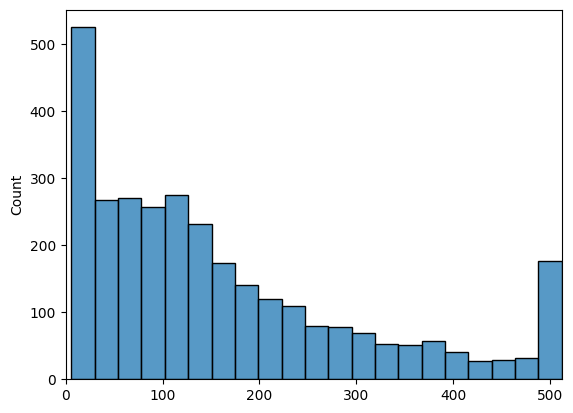

In [ ]:
token_counts = []
for text in X_train:
  token_count = len(tokenizer.encode(
    text,
    max_length=512,
    truncation=True
  ))
  token_counts.append(token_count)
sns.histplot(token_counts)
plt.xlim([0, 512]); #Para saber el numero de tokens que necesito

In [ ]:
class Dataset(Dataset):
  def __init__(
    self,
    data: pd.DataFrame,
    tokenizer: BertTokenizer,
    max_token_len: int = 512 #maximo numero de tokens
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]
    comment_text = data_row.Texto
    labels = data_row[LABEL_COLUMNS]
    encoding = self.tokenizer.encode_plus(
      comment_text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return dict(
      comment_text=comment_text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.FloatTensor(labels)
    )

#Clases para asistir la rutina de entrenamiento
class DataModule(pl.LightningDataModule):
  def __init__(self, train_df, test_df, tokenizer, batch_size=16, max_token_len=128):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    self.train_dataset = Dataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )
    self.test_dataset = Dataset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )
  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )
  def val_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )
  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

class ModeloBert(pl.LightningModule):
    def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
        super().__init__()
        self.bert = BertModel.from_pretrained(NOMBRE_MODELO, return_dict=True)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        self.criterion = nn.BCELoss()

        self.auroc_metrics = nn.ModuleList([AUROC(num_classes=1, task='binary') for _ in range(n_classes)])

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bert(input_ids, attention_mask=attention_mask)
        output = self.classifier(output.pooler_output)
        output = torch.sigmoid(output)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output

    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        # Update AUROC metrics
        for i, metric in enumerate(self.auroc_metrics):
            metric.update(outputs[:, i], labels[:, i].int())

        return loss

    def on_train_epoch_end(self, unused=None):
        # Compute and log AUROC for each class
        for i, name in enumerate(LABEL_COLUMNS):
            class_roc_auc = self.auroc_metrics[i].compute()
            self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)
            self.auroc_metrics[i].reset()  # Reset metrics for the next epoch


    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=2e-5)
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=self.n_warmup_steps,
            num_training_steps=self.n_training_steps
        )
        return dict(
            optimizer=optimizer,
            lr_scheduler=dict(
                scheduler=scheduler,
                interval='step'
            )
        )


In [ ]:
data_module = DataModule(
    train_dataset,
    test_dataset,
    tokenizer,
    batch_size = 16,
    max_token_len = 512
)

In [ ]:
modelo = BertModel.from_pretrained(NOMBRE_MODELO, return_dict=True)
modelo = ModeloBert(
    n_classes = len(LABEL_COLUMNS),
    n_warmup_steps = 7600, #Calculado basado en batchsize = 16 y 12 epocas, considerando 1/5 para el warmup
    n_training_steps = 38000
)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
checkpoint_callback = ModelCheckpoint(
  dirpath="/content/drive/MyDrive/model_checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

logger = TensorBoardLogger("lightning_logs", name="Bert primera prueba")
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5) #previene sobreajuste

In [ ]:
checkpoint_callback.best_model_path

''

In [ ]:
trainer = pl.Trainer(
  logger=logger,
  callbacks=[checkpoint_callback, early_stopping_callback],
  max_epochs=100, #Se van a probar con epochs, con earlystopping y un batchsize de 16.
  enable_progress_bar=True,
  enable_model_summary = True
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
modelo_entrenado = ModeloBert.load_from_checkpoint(
    '/content/drive/MyDrive/model_checkpoints/best-checkpoint-v1.ckpt',
    n_classes = len(LABEL_COLUMNS)
)
modelo_entrenado.eval()
modelo_entrenado.freeze()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelo_entrenado = modelo_entrenado.to(device)

val_dataset = Dataset(
  test_dataset,
  tokenizer,
  max_token_len=512
)

predictions = []
labels = []

for item in tqdm(val_dataset):
  _, prediction = modelo_entrenado(
    item["input_ids"].unsqueeze(dim=0).to(device),
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

  0%|          | 0/766 [00:00<?, ?it/s]

In [ ]:
accuracy = Accuracy(task='multilabel',num_labels=11,threshold = 0.5)
accuracy(predictions,labels)

tensor(0.9216)

In [ ]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix


y_pred = predictions.numpy()
y_true = labels.numpy()
upper, lower = 1, 0
y_pred = np.where(y_pred > 0.5, upper, lower)
print(classification_report(
  y_true,
  y_pred,
  target_names=LABEL_COLUMNS,
  zero_division=0
))

                        precision    recall  f1-score   support

       Debería (frase)       1.00      1.00      1.00         2
     Error del adivino       1.00      0.50      0.67         2
Etiquetamiento erróneo       1.00      1.00      1.00         1
         Filtro mental       1.00      0.50      0.67         2
              Labeling       0.00      0.00      0.00         1
      Lectura de mente       1.00      1.00      1.00         1
         Magnificación       1.00      0.50      0.67         2
       Personalización       1.00      1.00      1.00         1
Razonamiento emocional       1.00      0.50      0.67         2
   Sobregeneralización       1.00      1.00      1.00         1
           Todo o nada       1.00      1.00      1.00         1

             micro avg       1.00      0.69      0.81        16
             macro avg       0.91      0.73      0.79        16
          weighted avg       0.94      0.69      0.77        16
           samples avg       0.80     